In [420]:
%matplotlib inline 
import matplotlib
from pandas.tools.plotting import radviz
import pandas as pd
import nltk
import numpy
from numpy import linalg
import scipy
from nltk.stem.porter import *
stemmer = PorterStemmer()

In [583]:
class LSI(object):
	def __init__(self, stopwords, ignorechars, docs):
		# все слова которые встречаются в документах, и содержит номера документов в которых встречается каждое слово
		self.wdict = {}
		# dictionary - Ключевые слова в матрице слева   содержит коды слов
		self.dictionary = []
		# слова которые исключаем из анализа типа и, в, на
		self.stopwords = stopwords
		#содержит документы, в которых слова заменены их кодами из словаря        
		self.docs = []
		if type(ignorechars) == str: ignorechars = ignorechars.encode('utf-8')
		self.ignorechars = ignorechars
		# инициализируем сами документы
		for doc in docs: self.add_doc(doc)
		print(self.docs)
        
	def prepare(self):
		self.build()
		self.calc()

	def dic(self, word, add = False):
		if type(word) == str: word = word.encode('utf-8')
		# чистим от лишних символов
		word = word.lower().translate(None, self.ignorechars)
		word = word.decode('utf-8')
		# приводим к начальной форме NLTK http://text-processing.com/demo/stem/ 
		word = stemmer.stem(word)
		# если слово есть в словаре возвращаем его номер
		if word in self.dictionary: return self.dictionary.index(word)
		else:
			# если нет и стоит флаг автоматически добавлять то пополняем словари возвращаем код слова
			if add:
				#self.ready = False
				self.dictionary.append(word)
				return len(self.dictionary) - 1
			else: return None

	def add_doc(self, doc):
		#берем каждое слово из текущего документа и добавляем в dictionary  в self.dic
		#в words записываем вектор из номеров слов из словаря для данного документа     
		words = [self.dic(word, True) for word in doc.lower().split()]
		#print('документ',words)     
		print('стопы', self.stopwords)  
		self.docs.append(words)
		for word in words:
			if self.dictionary[word] in self.stopwords:  
				print('стопслово')
				continue
			elif word in self.wdict:   self.wdict[word].append(len(self.docs) - 1)
			else:                      self.wdict[word] = [len(self.docs) - 1]

	def build(self):
		print(self.wdict) 
		# убираем одиночные слова
		self.keys = [k for k in self.wdict.keys() if len(self.wdict[k]) > 0]
		self.keys.sort()
		print(self.keys)        
		# создаём пустую матрицу  
		self.A = numpy.zeros([len(self.keys), len(self.docs)])
		# наполняем эту матрицу
		for i, k in enumerate(self.keys):
			for d in self.wdict[k]:
				#должны определить, сколько раз слово встречается в документе 
                #d - номер документа, в котором есть слово
              
				self.A[i,d] += 1
		print(self.A)        

	def calc(self):
		#сингулярное разложение матриц (U, S Vt)
		self.U, self.S, self.Vt = numpy.linalg.svd(self.A)

	#определяем важность термина в зависимости от его встречаемости
	def TFIDF(self):
		# всего кол-во слов на документ
		wordsPerDoc = sum(self.A, axis=0)
		# сколько документов приходится на слово
		docsPerWord = sum(asarray(self.A > 0, 'i'), axis=1)
		rows, cols = self.A.shape
		for i in range(rows):
			for j in range(cols):
				self.A[i,j] = (self.A[i,j] / wordsPerDoc[j]) * log(float(cols) / docsPerWord[i])

	def dump_src(self):
		self.prepare()
		print ('Исходная матрица')
		print (self.A)   
		print ('Здесь представлен расчет матрицы ')
		for i, row in enumerate(self.A):
			print (self.dictionary[i], row)

	def print_svd(self):
		self.prepare()
		print ('Здесь сингулярные значения')
		print (self.S)
		print ('Здесь первые 3 колонки U матрица')
		for i, row in enumerate(self.U):
			print (self.dictionary[self.keys[i]], row[0:3])
		print ('Здесь первые 3 строчки Vt матрица')
		print (-1*self.Vt[0:3, :])

	def find(self, word):
		self.prepare()
		idx = -1
		idx = self.dic(word)
		if idx == -1:
			print ('слово не встерчается')
			return []
		if not idx in self.keys:
			print ('слово отброшено как не имеющее значения которое через stopwords')
			return []
		idx = self.keys.index(idx)
		print ('слово в поиске --- ', word, '= в словаре --- ', self.dictionary[self.keys[idx]], '.\n')
		# получаем координаты слова
		wx, wy = (-1 * self.U[:, 1:3])[idx]
		print ('координаты слова (idx, wx, wy, word) {}\t{:0.2f}\t{:0.2f}\t{}\n'.format(idx, wx, wy, word))
		arts = []
		xx, yy = -1 * self.Vt[1:3, :]
		for k, v in enumerate(self.docs):
			# получаем координаты документа
			ax, ay = xx[k], yy[k]
			#вычисляем расстояние между словом и документом
			dx, dy = float(wx - ax), float(wy - ay)
			arts.append((k, v, ax, ay, numpy.sqrt(dx * dx + dy * dy)))
		print('документы, отсортированные по ближайшему расстоянию (евклидово расстояние)\n')
		return sorted(arts, key = lambda a: a[4])

In [584]:
docs =[
	"Британская полиция знает о местонахождении основателя WikiLeaks Британская полиция",
	"В суде США США начинается процесс против россиянина, рассылавшего спам",
	"Церемонию вручения Нобелевской премии мира бойкотируют 19 стран",
	"В Великобритании арестован основатель сайта Wikileaks Джулиан Ассандж а в россии все хорошо",
	"Украина игнорирует церемонию вручения Нобелевской премии",
	"Шведский суд отказался рассматривать апелляцию основателя Wikileaks",
	"НАТО и США разработали планы обороны стран Балтии против России",
	"Полиция Великобритании нашла основателя WikiLeaks, но, не арестовала",
	"В Стокгольме и Осло сегодня состоится вручение Нобелевских премий"
]

In [585]:
ignorechars = ''',:'!'''
stopwords = ['в','на','о','об','не','но','а','и', '19', 'все']

In [586]:
lsa = LSI(stopwords, ignorechars, docs)

стопы ['в', 'на', 'о', 'об', 'не', 'но', 'а', 'и', '19', 'все']
стопслово
стопы ['в', 'на', 'о', 'об', 'не', 'но', 'а', 'и', '19', 'все']
стопслово
стопы ['в', 'на', 'о', 'об', 'не', 'но', 'а', 'и', '19', 'все']
стопслово
стопы ['в', 'на', 'о', 'об', 'не', 'но', 'а', 'и', '19', 'все']
стопслово
стопслово
стопслово
стопслово
стопы ['в', 'на', 'о', 'об', 'не', 'но', 'а', 'и', '19', 'все']
стопы ['в', 'на', 'о', 'об', 'не', 'но', 'а', 'и', '19', 'все']
стопы ['в', 'на', 'о', 'об', 'не', 'но', 'а', 'и', '19', 'все']
стопслово
стопы ['в', 'на', 'о', 'об', 'не', 'но', 'а', 'и', '19', 'все']
стопслово
стопслово
стопы ['в', 'на', 'о', 'об', 'не', 'но', 'а', 'и', '19', 'все']
стопслово
стопслово
[[0, 1, 2, 3, 4, 5, 6, 0, 1], [7, 8, 9, 9, 10, 11, 12, 13, 14, 15], [16, 17, 18, 19, 20, 21, 22, 23], [7, 24, 25, 26, 27, 6, 28, 29, 30, 7, 31, 32, 33], [34, 35, 16, 17, 18, 19], [36, 37, 38, 39, 40, 5, 6], [41, 42, 9, 43, 44, 45, 23, 46, 12, 31], [1, 24, 47, 5, 6, 48, 49, 50], [7, 51, 42, 52, 53, 54, 5

In [587]:
lsa.build()

{0: [0, 0], 1: [0, 0, 7], 2: [0], 4: [0], 5: [0, 5, 7], 6: [0, 3, 5, 7], 8: [1], 9: [1, 1, 6], 10: [1], 11: [1], 12: [1, 6], 13: [1], 14: [1], 15: [1], 16: [2, 4], 17: [2, 4], 18: [2, 4], 19: [2, 4], 20: [2], 21: [2], 23: [2, 6], 24: [3, 7], 25: [3], 26: [3], 27: [3], 28: [3], 29: [3], 31: [3, 6], 33: [3], 34: [4], 35: [4], 36: [5], 37: [5], 38: [5], 39: [5], 40: [5], 41: [6], 43: [6], 44: [6], 45: [6], 46: [6], 47: [7], 50: [7], 51: [8], 52: [8], 53: [8], 54: [8], 55: [8], 56: [8], 57: [8]}
[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57]
[[ 2.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 2.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  1.  0.  1.  0.]
 [ 1.  0.  0.  1.  0.  1.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  1.  0.  0.

In [588]:
lsa.dump_src()

{0: [0, 0], 1: [0, 0, 7], 2: [0], 4: [0], 5: [0, 5, 7], 6: [0, 3, 5, 7], 8: [1], 9: [1, 1, 6], 10: [1], 11: [1], 12: [1, 6], 13: [1], 14: [1], 15: [1], 16: [2, 4], 17: [2, 4], 18: [2, 4], 19: [2, 4], 20: [2], 21: [2], 23: [2, 6], 24: [3, 7], 25: [3], 26: [3], 27: [3], 28: [3], 29: [3], 31: [3, 6], 33: [3], 34: [4], 35: [4], 36: [5], 37: [5], 38: [5], 39: [5], 40: [5], 41: [6], 43: [6], 44: [6], 45: [6], 46: [6], 47: [7], 50: [7], 51: [8], 52: [8], 53: [8], 54: [8], 55: [8], 56: [8], 57: [8]}
[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57]
[[ 2.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 2.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  1.  0.  1.  0.]
 [ 1.  0.  0.  1.  0.  1.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  1.  0.  0.

In [589]:
lsa.calc()

In [590]:
lsa.print_svd()

{0: [0, 0], 1: [0, 0, 7], 2: [0], 4: [0], 5: [0, 5, 7], 6: [0, 3, 5, 7], 8: [1], 9: [1, 1, 6], 10: [1], 11: [1], 12: [1, 6], 13: [1], 14: [1], 15: [1], 16: [2, 4], 17: [2, 4], 18: [2, 4], 19: [2, 4], 20: [2], 21: [2], 23: [2, 6], 24: [3, 7], 25: [3], 26: [3], 27: [3], 28: [3], 29: [3], 31: [3, 6], 33: [3], 34: [4], 35: [4], 36: [5], 37: [5], 38: [5], 39: [5], 40: [5], 41: [6], 43: [6], 44: [6], 45: [6], 46: [6], 47: [7], 50: [7], 51: [8], 52: [8], 53: [8], 54: [8], 55: [8], 56: [8], 57: [8]}
[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57]
[[ 2.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 2.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  1.  0.  1.  0.]
 [ 1.  0.  0.  1.  0.  1.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  1.  0.  0.

In [591]:
word= "процесс"
x = []
y = []
dots = []
for res in lsa.find(word):
	print('номер документа в списке  | растояние |  документ разложеный на коды  |  сам документ')
	print (res[0], res[4], res[1], docs[res[0]])
	#print('k - номер документа\t|\tдокумент в кодах\t|\tax\t|\tay\t|\tевклидово расстояние')
	#print(res)

{0: [0, 0], 1: [0, 0, 7], 2: [0], 4: [0], 5: [0, 5, 7], 6: [0, 3, 5, 7], 8: [1], 9: [1, 1, 6], 10: [1], 11: [1], 12: [1, 6], 13: [1], 14: [1], 15: [1], 16: [2, 4], 17: [2, 4], 18: [2, 4], 19: [2, 4], 20: [2], 21: [2], 23: [2, 6], 24: [3, 7], 25: [3], 26: [3], 27: [3], 28: [3], 29: [3], 31: [3, 6], 33: [3], 34: [4], 35: [4], 36: [5], 37: [5], 38: [5], 39: [5], 40: [5], 41: [6], 43: [6], 44: [6], 45: [6], 46: [6], 47: [7], 50: [7], 51: [8], 52: [8], 53: [8], 54: [8], 55: [8], 56: [8], 57: [8]}
[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57]
[[ 2.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 2.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  1.  0.  1.  0.]
 [ 1.  0.  0.  1.  0.  1.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  1.  0.  0.

In [592]:
#print(lsa.U[:,1:3])
df = pd.DataFrame(-1*lsa.U[:,1:3])
#df.insert(0,'x':lsa.U[:,1:2]) 
#df.insert(1,'y':lsa.U[:,2:3])
df = df.rename(columns={0:'x', 1:'y'})
df.insert(2,'dots', [lsa.dictionary[i] for i in lsa.keys])
df

,x,y,dots
0,-0.055777,0.005018,британская
1,-0.066708,0.005212,полиция
2,-0.027889,0.002509,знает
3,-0.027889,0.002509,местонахождении
4,-0.047279,0.002885,основателя
5,-0.022951,-0.001874,wikileak
6,0.212246,0.071100,суде
7,0.587361,0.131710,сша
8,0.212246,0.071100,начинается
9,0.212246,0.071100,процесс


/Users/anastasiapanfilova/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


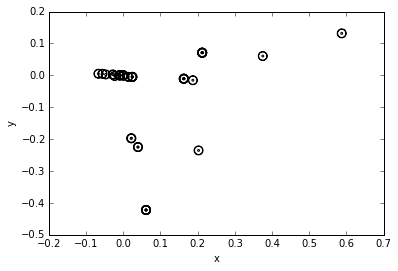

In [593]:
df.plot(kind='scatter', x='x', y='y', s=80, marker=r'$\odot$', facecolors='none', edgecolors='black')

In [594]:
from bokeh.plotting import Figure
from bokeh.models import ColumnDataSource, HoverTool, HBox, VBoxForm
from bokeh.models.widgets import Slider, Select, TextInput
from bokeh.io import curdoc
from bokeh.sampledata.movies_data import movie_path
from bokeh.plotting import figure, output_file, output_notebook, show, ColumnDataSource, gridplot
from bokeh.models import HoverTool, DatetimeTickFormatter

In [595]:
source = ColumnDataSource(data=dict(x=df.x, y=df.y, dots=df.dots))

hover = HoverTool(tooltips=[
    ("x","@x"),
    ("y", "@y"),
    ("dots", "@dots")
])

TOOLS = "pan, wheel_zoom, box_zoom, reset, save, box_select, crosshair"

output_notebook()
p = Figure(plot_height=600, plot_width=800, title="", tools=[hover, TOOLS])
p.circle(df.x, df.y, source=source, size=10, line_color="navy", fill_color="orange", fill_alpha=0.5)
show(p)

BokehJS successfully loaded.